In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1
)
from truth import IeeeGroundTruth

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [34]:
truth = IeeeGroundTruth(3, 1, directory = 'channel_data3')  # basic method
truth.align_rgb_bvp()
truth.fill_nans()
truth.process_rgb()
truth.process_bvp()
truth.interpolate_bvp()

In [35]:
truth.prepare_data_for_ml()

,r,g,b,bvp
0,-0.102476,-0.160240,-0.177455,0.277289
1,-0.038763,-0.082477,-0.100510,0.395085
2,0.135007,0.005712,-0.023287,0.512880
3,-0.004379,-0.054162,-0.069736,0.595264
4,-0.040759,-0.094076,-0.113783,0.672200
...,...,...,...,...
8741,0.288112,0.283524,0.222940,0.001435
8742,0.285643,0.278566,0.220744,0.001649
8743,0.298601,0.280505,0.216279,0.001741
8744,0.253421,0.247043,0.213006,0.001752


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


class RppgMl:
    
    def __init__(self, data, label_col = 'bvp', test_size = 0.2, random_state = 42):

        self.data = data
        self.label_col = label_col
        self.test_size = test_size
        self.random_state = random_state

        self.X = self.data.drop(columns = [self.label_col])
        self.y = self.data[self.label_col]
        
        (
            self.X_train, self.X_test,
            self.y_train, self.y_test
        ) = train_test_split(self.X, self.y, test_size = self.test_size, random_state = self.random_state)

        self.X_train = self.X_train.to_numpy()
        self.X_test = self.X_test.to_numpy()
        self.y_train = self.y_train.to_numpy()
        self.y_test = self.y_test.to_numpy()
    
    def train_skl(self, model):
        self.skl_model = model().fit(self.X_train, self.y_train)

    def predict_skl(self, x):
        return self.skl_model.predict(x)
    
    def eval_skl(self):
        return mean_squared_error(self.y_test, self.predict_skl(self.X_test))

In [37]:
ml = RppgMl(truth.prepare_data_for_ml())
ml.train_skl(LinearRegression)
ml.eval_skl()

0.006814127213612303

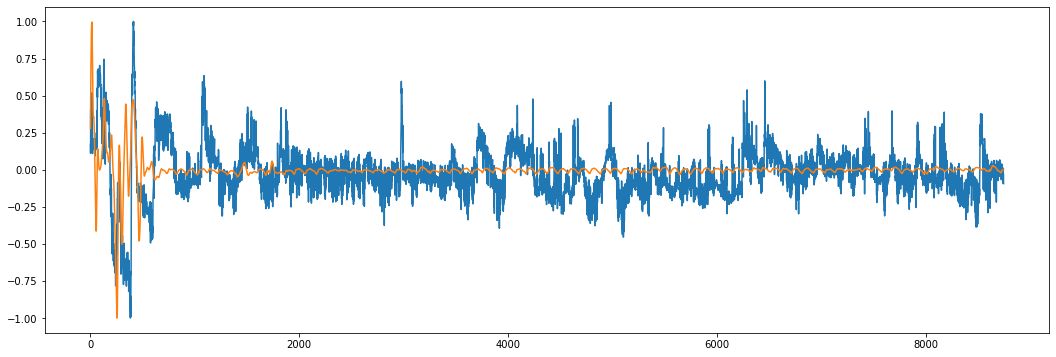

In [38]:
sam = ml.predict_skl(truth.rgb)
sam = normalize_amplitude_to_1(sam)
plt.plot(sam)
plt.plot(truth.bvp_interp)